In [ ]:
!pip install -qq seaborn
!pip install -qq torchsummary
!pip install -qq gdown
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms
import json
from torch.utils.data import Dataset, DataLoader
import os
import torch.optim as optim
from PIL import Image
import random
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import math
from torchsummary import summary
import shutil
from io import BytesIO

In [ ]:
!gdown https://drive.google.com/uc?id=1RxgARkkEoV8ACVBe2hcBNmTH1vVk5MGv
!unzip -qq ./dataset.zip -d ./

Downloading...
From: https://drive.google.com/uc?id=1RxgARkkEoV8ACVBe2hcBNmTH1vVk5MGv
To: /content/dataset.zip
100% 2.84G/2.84G [01:00<00:00, 47.3MB/s]


In [ ]:
torch.cuda.empty_cache()

device = "cuda:0" if torch.cuda.is_available() else "cpu"


class ChessboardCNN(nn.Module):
    def __init__(self):
        super(ChessboardCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.dropout1 = nn.Dropout(0.2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout2 = nn.Dropout(0.2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.dropout3 = nn.Dropout(0.2)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.dropout4 = nn.Dropout(0.25)
        self.conv5 = nn.Conv2d(256, 512, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.dropout5 = nn.Dropout(0.25)
        self.conv6 = nn.Conv2d(512, 256, 3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.dropout6 = nn.Dropout(0.15)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * 5 * 5, 64*13)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout1(x)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout2(x)
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.dropout3(x)
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.dropout4(x)
        x = self.pool(F.relu(self.bn5(self.conv5(x))))
        x = self.dropout5(x)
        x = self.pool(F.relu(self.bn6(self.conv6(x))))
        x = self.dropout6(x)
        x = self.flatten(x)
        x = self.fc1(x)
        return x.view(-1, 64, 13)

model = ChessboardCNN().to(device)
summary(model, input_size=(3, 320, 320))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 320, 320]             896
       BatchNorm2d-2         [-1, 32, 320, 320]              64
         MaxPool2d-3         [-1, 32, 160, 160]               0
           Dropout-4         [-1, 32, 160, 160]               0
            Conv2d-5         [-1, 64, 160, 160]          18,496
       BatchNorm2d-6         [-1, 64, 160, 160]             128
         MaxPool2d-7           [-1, 64, 80, 80]               0
           Dropout-8           [-1, 64, 80, 80]               0
            Conv2d-9          [-1, 128, 80, 80]          73,856
      BatchNorm2d-10          [-1, 128, 80, 80]             256
        MaxPool2d-11          [-1, 128, 40, 40]               0
          Dropout-12          [-1, 128, 40, 40]               0
           Conv2d-13          [-1, 256, 40, 40]         295,168
      BatchNorm2d-14          [-1, 256,

In [ ]:
class ChessDataset(Dataset):
    def __init__(self, root_dir, transform=None, augment=False):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.endswith('.png')]
        self.label_map = {"empty": 0, "p": 1, "P": 2, "n": 3, "N": 4, "b": 5, "B": 6, "r": 7, "R": 8, "q": 9, "Q": 10, "k": 11, "K": 12}
        self.augment = augment

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label_path = img_path.replace('.png', '.json')
        label = self._load_label(label_path)

        if self.transform:
            if self.augment and img_path.startswith('aug_'):
                image = train_transform(image)
            else:
                image = test_transform(image)
        return image, torch.tensor(label, dtype=torch.long)

    def _load_label(self, label_path):
        with open(label_path, 'r') as file:
            annotations = json.load(file)
        label = [self.label_map[annotations[key]] for key in annotations.keys()]
        return label

mean = [0.6024, 0.4147, 0.2778]
std = [0.1996, 0.1624, 0.1518]
saturation_range = (0.82, 1.18)
brightness_range = (0.65, 1.35)
exposure_range = (0.95, 1.05)

train_transform = transforms.Compose([
    transforms.Resize((320, 320)),
    transforms.RandomAffine(degrees=(-2, 2)),
    transforms.ColorJitter(brightness=brightness_range,contrast=saturation_range,saturation=saturation_range),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

test_transform = transforms.Compose([
    transforms.Resize((320, 320)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

In [ ]:
directory_path = './blender_dataset'

def process_and_delete_json_files(directory_path):
    json_count = 0

    for filename in os.listdir(directory_path):
        if filename.endswith('.json'):
            file_path = os.path.join(directory_path, filename)
            with open(file_path, 'r') as file:
                data = json.load(file)

            non_empty_count = sum(1 for value in data.values() if value != 'empty')
            target_folder = os.path.join(directory_path, str(non_empty_count))
            os.makedirs(target_folder, exist_ok=True)

            new_json_path = os.path.join(target_folder, filename)
            shutil.move(file_path, new_json_path)

            png_filename = os.path.splitext(filename)[0] + '.png'
            png_file_path = os.path.join(directory_path, png_filename)
            if os.path.exists(png_file_path):
                new_png_path = os.path.join(target_folder, png_filename)
                shutil.move(png_file_path, new_png_path)
            json_count += 1

    return json_count
json_count = process_and_delete_json_files(directory_path)
print(f"Liczba przetworzonych plików JSON: {json_count}")

Liczba przetworzonych plików JSON: 4888


In [ ]:
def split_dataset(root_dir, train_dir, val_dir, test_dir, train_pct, val_pct, aug_range=0, random_seed=42):
    if random_seed is not None:
        random.seed(random_seed)

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    files = [f for f in os.listdir(root_dir) if f.endswith('.png')]
    random.shuffle(files)

    total_files = len(files)
    train_index = int(total_files * train_pct)
    val_index = train_index + int(total_files * val_pct)

    train_files = files[:train_index]
    val_files = files[train_index:val_index]
    test_files = files[val_index:]

    def move_files(file_list, destination, duplicate_for_train=False):
        for file in file_list:
            original_file_path = os.path.join(root_dir, file)
            new_file_path = os.path.join(destination, file)

            shutil.move(original_file_path, new_file_path)

            original_json_path = original_file_path.replace('.png', '.json')
            if os.path.exists(original_json_path):
                new_json_path = os.path.join(destination, file.replace('.png', '.json'))
                shutil.move(original_json_path, new_json_path)

            if duplicate_for_train:
                for i in range(aug_range):
                    aug_file_path = os.path.join(destination, 'aug_' + str(i) + file)
                    shutil.copy(new_file_path, aug_file_path)

                    aug_json_path = os.path.join(destination, 'aug_' + str(i) + file.replace('.png', '.json'))
                    shutil.copy(new_json_path, aug_json_path)

    move_files(train_files, train_dir, duplicate_for_train=True)
    move_files(val_files, val_dir, duplicate_for_train=False)
    move_files(test_files, test_dir, duplicate_for_train=False)

train_dir = './train'
val_dir = './val'
test_dir = './test'

aug_values = [352, 175, 69, 10, 7, 4, 4, 4, 4, 2, 3, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 3, 0, 3, 0, 4, 0, 4, 0]
for i, aug_value in zip(range(0, 31), aug_values):
    split_dataset(f"./blender_dataset/{2+i}", train_dir, val_dir, test_dir, train_pct=0.8, val_pct=0.10, aug_range=aug_value, random_seed=42)

In [ ]:
bs = 16
train_dataset = ChessDataset(root_dir='./train', transform=True, augment=True)
test_dataset = ChessDataset(root_dir='./test', transform=True, augment=False)
val_dataset = ChessDataset(root_dir='./val', transform=True, augment=False)

test_data_loader = DataLoader(test_dataset, bs, shuffle=False)
print(len(test_data_loader))

train_data_loader = DataLoader(train_dataset, bs, shuffle=True)
print(len(train_data_loader))

val_data_loader = DataLoader(val_dataset, bs, shuffle=True)
print(len(val_data_loader))

33
660
30


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Dokladnosc dla klasy 0: 99.91%
Dokladnosc dla klasy 1: 21.06%
Dokladnosc dla klasy 2: 25.14%
Dokladnosc dla klasy 3: 10.22%
Dokladnosc dla klasy 4: 2.92%
Dokladnosc dla klasy 5: 10.17%
Dokladnosc dla klasy 6: 15.30%
Dokladnosc dla klasy 7: 14.62%
Dokladnosc dla klasy 8: 22.68%
Dokladnosc dla klasy 9: 4.61%
Dokladnosc dla klasy 10: 2.01%
Dokladnosc dla klasy 11: 27.18%
Dokladnosc dla klasy 12: 38.64%
Epoka 1, Strata Treningowa: 0.6587, Dokładność Treningowa: 80.27%, Strata Walidacyjna: 1.0450


  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Dokladnosc dla klasy 0: 99.12%
Dokladnosc dla klasy 1: 83.05%
Dokladnosc dla klasy 2: 82.64%
Dokladnosc dla klasy 3: 48.47%
Dokladnosc dla klasy 4: 42.50%
Dokladnosc dla klasy 5: 46.64%
Dokladnosc dla klasy 6: 42.45%
Dokladnosc dla klasy 7: 67.80%
Dokladnosc dla klasy 8: 68.78%
Dokladnosc dla klasy 9: 36.18%
Dokladnosc dla klasy 10: 43.29%
Dokladnosc dla klasy 11: 66.03%
Dokladnosc dla klasy 12: 74.95%
Epoka 2, Strata Treningowa: 0.3256, Dokładność Treningowa: 90.06%, Strata Walidacyjna: 0.3772


  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Dokladnosc dla klasy 0: 99.24%
Dokladnosc dla klasy 1: 87.54%
Dokladnosc dla klasy 2: 88.77%
Dokladnosc dla klasy 3: 58.28%
Dokladnosc dla klasy 4: 53.33%
Dokladnosc dla klasy 5: 54.13%
Dokladnosc dla klasy 6: 50.48%
Dokladnosc dla klasy 7: 75.33%
Dokladnosc dla klasy 8: 72.90%
Dokladnosc dla klasy 9: 41.78%
Dokladnosc dla klasy 10: 45.30%
Dokladnosc dla klasy 11: 74.10%
Dokladnosc dla klasy 12: 77.28%
Epoka 3, Strata Treningowa: 0.2158, Dokładność Treningowa: 93.37%, Strata Walidacyjna: 0.3117


  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Dokladnosc dla klasy 0: 99.15%
Dokladnosc dla klasy 1: 89.66%
Dokladnosc dla klasy 2: 92.41%
Dokladnosc dla klasy 3: 59.51%
Dokladnosc dla klasy 4: 52.71%
Dokladnosc dla klasy 5: 55.66%
Dokladnosc dla klasy 6: 50.86%
Dokladnosc dla klasy 7: 75.92%
Dokladnosc dla klasy 8: 74.67%
Dokladnosc dla klasy 9: 46.38%
Dokladnosc dla klasy 10: 52.35%
Dokladnosc dla klasy 11: 78.98%
Dokladnosc dla klasy 12: 78.13%
Epoka 4, Strata Treningowa: 0.1578, Dokładność Treningowa: 95.26%, Strata Walidacyjna: 0.2808


  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Dokladnosc dla klasy 0: 98.75%
Dokladnosc dla klasy 1: 91.96%
Dokladnosc dla klasy 2: 92.64%
Dokladnosc dla klasy 3: 64.01%
Dokladnosc dla klasy 4: 58.54%
Dokladnosc dla klasy 5: 63.72%
Dokladnosc dla klasy 6: 58.51%
Dokladnosc dla klasy 7: 76.81%
Dokladnosc dla klasy 8: 74.52%
Dokladnosc dla klasy 9: 49.67%
Dokladnosc dla klasy 10: 54.70%
Dokladnosc dla klasy 11: 78.77%
Dokladnosc dla klasy 12: 80.04%
Epoka 5, Strata Treningowa: 0.1200, Dokładność Treningowa: 96.58%, Strata Walidacyjna: 0.2634


  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Dokladnosc dla klasy 0: 98.64%
Dokladnosc dla klasy 1: 92.79%
Dokladnosc dla klasy 2: 93.79%
Dokladnosc dla klasy 3: 60.94%
Dokladnosc dla klasy 4: 61.46%
Dokladnosc dla klasy 5: 67.37%
Dokladnosc dla klasy 6: 65.20%
Dokladnosc dla klasy 7: 77.70%
Dokladnosc dla klasy 8: 76.29%
Dokladnosc dla klasy 9: 50.66%
Dokladnosc dla klasy 10: 56.71%
Dokladnosc dla klasy 11: 80.68%
Dokladnosc dla klasy 12: 81.53%
Epoka 6, Strata Treningowa: 0.0952, Dokładność Treningowa: 97.49%, Strata Walidacyjna: 0.2418


  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Dokladnosc dla klasy 0: 99.43%
Dokladnosc dla klasy 1: 94.15%
Dokladnosc dla klasy 2: 93.83%
Dokladnosc dla klasy 3: 63.19%
Dokladnosc dla klasy 4: 65.62%
Dokladnosc dla klasy 5: 70.06%
Dokladnosc dla klasy 6: 64.05%
Dokladnosc dla klasy 7: 79.17%
Dokladnosc dla klasy 8: 78.06%
Dokladnosc dla klasy 9: 51.64%
Dokladnosc dla klasy 10: 59.40%
Dokladnosc dla klasy 11: 81.32%
Dokladnosc dla klasy 12: 83.23%
Epoka 7, Strata Treningowa: 0.0783, Dokładność Treningowa: 98.10%, Strata Walidacyjna: 0.2122


  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Dokladnosc dla klasy 0: 99.41%
Dokladnosc dla klasy 1: 95.62%
Dokladnosc dla klasy 2: 95.71%
Dokladnosc dla klasy 3: 60.94%
Dokladnosc dla klasy 4: 62.08%
Dokladnosc dla klasy 5: 68.33%
Dokladnosc dla klasy 6: 66.54%
Dokladnosc dla klasy 7: 81.09%
Dokladnosc dla klasy 8: 76.44%
Dokladnosc dla klasy 9: 56.58%
Dokladnosc dla klasy 10: 61.74%
Dokladnosc dla klasy 11: 84.08%
Dokladnosc dla klasy 12: 86.41%
Epoka 8, Strata Treningowa: 0.0659, Dokładność Treningowa: 98.57%, Strata Walidacyjna: 0.1977


  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Dokladnosc dla klasy 0: 99.46%
Dokladnosc dla klasy 1: 96.49%
Dokladnosc dla klasy 2: 96.40%
Dokladnosc dla klasy 3: 64.62%
Dokladnosc dla klasy 4: 65.42%
Dokladnosc dla klasy 5: 73.32%
Dokladnosc dla klasy 6: 71.32%
Dokladnosc dla klasy 7: 81.24%
Dokladnosc dla klasy 8: 80.56%
Dokladnosc dla klasy 9: 60.53%
Dokladnosc dla klasy 10: 63.76%
Dokladnosc dla klasy 11: 83.44%
Dokladnosc dla klasy 12: 84.93%
Epoka 9, Strata Treningowa: 0.0569, Dokładność Treningowa: 98.87%, Strata Walidacyjna: 0.1824


  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Dokladnosc dla klasy 0: 99.58%
Dokladnosc dla klasy 1: 96.87%
Dokladnosc dla klasy 2: 96.70%
Dokladnosc dla klasy 3: 65.24%
Dokladnosc dla klasy 4: 66.88%
Dokladnosc dla klasy 5: 74.86%
Dokladnosc dla klasy 6: 70.94%
Dokladnosc dla klasy 7: 82.87%
Dokladnosc dla klasy 8: 79.68%
Dokladnosc dla klasy 9: 60.20%
Dokladnosc dla klasy 10: 66.11%
Dokladnosc dla klasy 11: 84.93%
Dokladnosc dla klasy 12: 87.05%
Epoka 10, Strata Treningowa: 0.0516, Dokładność Treningowa: 99.04%, Strata Walidacyjna: 0.1703


  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Dokladnosc dla klasy 0: 99.56%
Dokladnosc dla klasy 1: 96.41%
Dokladnosc dla klasy 2: 96.67%
Dokladnosc dla klasy 3: 67.28%
Dokladnosc dla klasy 4: 68.12%
Dokladnosc dla klasy 5: 76.01%
Dokladnosc dla klasy 6: 72.85%
Dokladnosc dla klasy 7: 81.68%
Dokladnosc dla klasy 8: 79.82%
Dokladnosc dla klasy 9: 67.11%
Dokladnosc dla klasy 10: 71.14%
Dokladnosc dla klasy 11: 85.14%
Dokladnosc dla klasy 12: 84.29%
Epoka 11, Strata Treningowa: 0.0467, Dokładność Treningowa: 99.18%, Strata Walidacyjna: 0.1664


  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Dokladnosc dla klasy 0: 99.69%
Dokladnosc dla klasy 1: 97.09%
Dokladnosc dla klasy 2: 97.28%
Dokladnosc dla klasy 3: 67.48%
Dokladnosc dla klasy 4: 72.08%
Dokladnosc dla klasy 5: 76.39%
Dokladnosc dla klasy 6: 72.08%
Dokladnosc dla klasy 7: 82.42%
Dokladnosc dla klasy 8: 81.89%
Dokladnosc dla klasy 9: 62.50%
Dokladnosc dla klasy 10: 70.13%
Dokladnosc dla klasy 11: 86.84%
Dokladnosc dla klasy 12: 87.47%
Epoka 12, Strata Treningowa: 0.0432, Dokładność Treningowa: 99.29%, Strata Walidacyjna: 0.1522


  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Dokladnosc dla klasy 0: 99.48%
Dokladnosc dla klasy 1: 97.73%
Dokladnosc dla klasy 2: 97.85%
Dokladnosc dla klasy 3: 69.53%
Dokladnosc dla klasy 4: 73.96%
Dokladnosc dla klasy 5: 77.16%
Dokladnosc dla klasy 6: 72.85%
Dokladnosc dla klasy 7: 81.68%
Dokladnosc dla klasy 8: 81.00%
Dokladnosc dla klasy 9: 67.43%
Dokladnosc dla klasy 10: 72.48%
Dokladnosc dla klasy 11: 87.47%
Dokladnosc dla klasy 12: 86.41%
Epoka 13, Strata Treningowa: 0.0404, Dokładność Treningowa: 99.37%, Strata Walidacyjna: 0.1499


  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Dokladnosc dla klasy 0: 99.71%
Dokladnosc dla klasy 1: 98.00%
Dokladnosc dla klasy 2: 98.05%
Dokladnosc dla klasy 3: 71.98%
Dokladnosc dla klasy 4: 73.54%
Dokladnosc dla klasy 5: 77.93%
Dokladnosc dla klasy 6: 75.33%
Dokladnosc dla klasy 7: 83.90%
Dokladnosc dla klasy 8: 83.51%
Dokladnosc dla klasy 9: 70.39%
Dokladnosc dla klasy 10: 72.48%
Dokladnosc dla klasy 11: 89.17%
Dokladnosc dla klasy 12: 88.11%
Epoka 14, Strata Treningowa: 0.0375, Dokładność Treningowa: 99.45%, Strata Walidacyjna: 0.1336


  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Dokladnosc dla klasy 0: 99.70%
Dokladnosc dla klasy 1: 97.70%
Dokladnosc dla klasy 2: 97.70%
Dokladnosc dla klasy 3: 72.60%
Dokladnosc dla klasy 4: 76.04%
Dokladnosc dla klasy 5: 78.12%
Dokladnosc dla klasy 6: 77.06%
Dokladnosc dla klasy 7: 83.90%
Dokladnosc dla klasy 8: 84.09%
Dokladnosc dla klasy 9: 71.05%
Dokladnosc dla klasy 10: 71.14%
Dokladnosc dla klasy 11: 89.38%
Dokladnosc dla klasy 12: 88.75%
Epoka 15, Strata Treningowa: 0.0354, Dokładność Treningowa: 99.50%, Strata Walidacyjna: 0.1295


  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Dokladnosc dla klasy 0: 99.86%
Dokladnosc dla klasy 1: 98.19%
Dokladnosc dla klasy 2: 98.08%
Dokladnosc dla klasy 3: 74.64%
Dokladnosc dla klasy 4: 75.42%
Dokladnosc dla klasy 5: 78.89%
Dokladnosc dla klasy 6: 76.10%
Dokladnosc dla klasy 7: 86.71%
Dokladnosc dla klasy 8: 85.13%
Dokladnosc dla klasy 9: 71.71%
Dokladnosc dla klasy 10: 73.83%
Dokladnosc dla klasy 11: 90.23%
Dokladnosc dla klasy 12: 89.81%
Epoka 16, Strata Treningowa: 0.0334, Dokładność Treningowa: 99.54%, Strata Walidacyjna: 0.1193


  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Dokladnosc dla klasy 0: 99.85%
Dokladnosc dla klasy 1: 98.11%
Dokladnosc dla klasy 2: 98.47%
Dokladnosc dla klasy 3: 74.03%
Dokladnosc dla klasy 4: 76.88%
Dokladnosc dla klasy 5: 80.23%
Dokladnosc dla klasy 6: 78.39%
Dokladnosc dla klasy 7: 86.56%
Dokladnosc dla klasy 8: 86.01%
Dokladnosc dla klasy 9: 71.05%
Dokladnosc dla klasy 10: 71.48%
Dokladnosc dla klasy 11: 91.51%
Dokladnosc dla klasy 12: 89.81%
Epoka 17, Strata Treningowa: 0.0317, Dokładność Treningowa: 99.58%, Strata Walidacyjna: 0.1133


  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Dokladnosc dla klasy 0: 99.92%
Dokladnosc dla klasy 1: 98.72%
Dokladnosc dla klasy 2: 98.05%
Dokladnosc dla klasy 3: 79.96%
Dokladnosc dla klasy 4: 78.54%
Dokladnosc dla klasy 5: 80.23%
Dokladnosc dla klasy 6: 80.31%
Dokladnosc dla klasy 7: 88.48%
Dokladnosc dla klasy 8: 88.51%
Dokladnosc dla klasy 9: 71.71%
Dokladnosc dla klasy 10: 74.83%
Dokladnosc dla klasy 11: 92.78%
Dokladnosc dla klasy 12: 89.81%
Epoka 18, Strata Treningowa: 0.0304, Dokładność Treningowa: 99.63%, Strata Walidacyjna: 0.1049


  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Dokladnosc dla klasy 0: 99.92%
Dokladnosc dla klasy 1: 98.41%
Dokladnosc dla klasy 2: 98.51%
Dokladnosc dla klasy 3: 81.80%
Dokladnosc dla klasy 4: 80.42%
Dokladnosc dla klasy 5: 80.81%
Dokladnosc dla klasy 6: 81.45%
Dokladnosc dla klasy 7: 91.73%
Dokladnosc dla klasy 8: 89.40%
Dokladnosc dla klasy 9: 75.33%
Dokladnosc dla klasy 10: 76.51%
Dokladnosc dla klasy 11: 92.57%
Dokladnosc dla klasy 12: 92.14%
Epoka 19, Strata Treningowa: 0.0292, Dokładność Treningowa: 99.65%, Strata Walidacyjna: 0.0984


  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Dokladnosc dla klasy 0: 99.89%
Dokladnosc dla klasy 1: 98.38%
Dokladnosc dla klasy 2: 98.85%
Dokladnosc dla klasy 3: 83.23%
Dokladnosc dla klasy 4: 81.46%
Dokladnosc dla klasy 5: 82.73%
Dokladnosc dla klasy 6: 82.98%
Dokladnosc dla klasy 7: 90.10%
Dokladnosc dla klasy 8: 89.99%
Dokladnosc dla klasy 9: 75.99%
Dokladnosc dla klasy 10: 75.84%
Dokladnosc dla klasy 11: 92.14%
Dokladnosc dla klasy 12: 91.08%
Epoka 20, Strata Treningowa: 0.0281, Dokładność Treningowa: 99.68%, Strata Walidacyjna: 0.0935


  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Dokladnosc dla klasy 0: 99.91%
Dokladnosc dla klasy 1: 98.79%
Dokladnosc dla klasy 2: 98.97%
Dokladnosc dla klasy 3: 84.87%
Dokladnosc dla klasy 4: 83.54%
Dokladnosc dla klasy 5: 83.11%
Dokladnosc dla klasy 6: 83.75%
Dokladnosc dla klasy 7: 92.32%
Dokladnosc dla klasy 8: 91.75%
Dokladnosc dla klasy 9: 76.32%
Dokladnosc dla klasy 10: 77.52%
Dokladnosc dla klasy 11: 93.21%
Dokladnosc dla klasy 12: 92.14%
Epoka 21, Strata Treningowa: 0.0270, Dokładność Treningowa: 99.71%, Strata Walidacyjna: 0.0837


  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Dokladnosc dla klasy 0: 99.84%
Dokladnosc dla klasy 1: 98.68%
Dokladnosc dla klasy 2: 98.93%
Dokladnosc dla klasy 3: 86.71%
Dokladnosc dla klasy 4: 85.83%
Dokladnosc dla klasy 5: 86.56%
Dokladnosc dla klasy 6: 85.28%
Dokladnosc dla klasy 7: 92.76%
Dokladnosc dla klasy 8: 91.90%
Dokladnosc dla klasy 9: 75.66%
Dokladnosc dla klasy 10: 78.86%
Dokladnosc dla klasy 11: 92.78%
Dokladnosc dla klasy 12: 92.14%
Epoka 22, Strata Treningowa: 0.0262, Dokładność Treningowa: 99.72%, Strata Walidacyjna: 0.0827


  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Dokladnosc dla klasy 0: 99.88%
Dokladnosc dla klasy 1: 98.91%
Dokladnosc dla klasy 2: 99.12%
Dokladnosc dla klasy 3: 87.12%
Dokladnosc dla klasy 4: 86.67%
Dokladnosc dla klasy 5: 85.60%
Dokladnosc dla klasy 6: 87.95%
Dokladnosc dla klasy 7: 93.21%
Dokladnosc dla klasy 8: 91.90%
Dokladnosc dla klasy 9: 77.96%
Dokladnosc dla klasy 10: 80.54%
Dokladnosc dla klasy 11: 93.84%
Dokladnosc dla klasy 12: 93.84%
Epoka 23, Strata Treningowa: 0.0258, Dokładność Treningowa: 99.73%, Strata Walidacyjna: 0.0774


  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Dokladnosc dla klasy 0: 99.96%
Dokladnosc dla klasy 1: 98.75%
Dokladnosc dla klasy 2: 98.43%
Dokladnosc dla klasy 3: 86.50%
Dokladnosc dla klasy 4: 83.75%
Dokladnosc dla klasy 5: 87.14%
Dokladnosc dla klasy 6: 90.06%
Dokladnosc dla klasy 7: 95.13%
Dokladnosc dla klasy 8: 94.26%
Dokladnosc dla klasy 9: 78.62%
Dokladnosc dla klasy 10: 77.85%
Dokladnosc dla klasy 11: 94.69%
Dokladnosc dla klasy 12: 92.36%
Epoka 24, Strata Treningowa: 0.0248, Dokładność Treningowa: 99.75%, Strata Walidacyjna: 0.0743


  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Dokladnosc dla klasy 0: 99.92%
Dokladnosc dla klasy 1: 98.79%
Dokladnosc dla klasy 2: 99.00%
Dokladnosc dla klasy 3: 89.57%
Dokladnosc dla klasy 4: 88.75%
Dokladnosc dla klasy 5: 88.10%
Dokladnosc dla klasy 6: 90.06%
Dokladnosc dla klasy 7: 94.24%
Dokladnosc dla klasy 8: 93.96%
Dokladnosc dla klasy 9: 79.61%
Dokladnosc dla klasy 10: 81.54%
Dokladnosc dla klasy 11: 94.27%
Dokladnosc dla klasy 12: 94.48%
Epoka 25, Strata Treningowa: 0.0249, Dokładność Treningowa: 99.74%, Strata Walidacyjna: 0.0699


  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Dokladnosc dla klasy 0: 99.93%
Dokladnosc dla klasy 1: 98.79%
Dokladnosc dla klasy 2: 99.04%
Dokladnosc dla klasy 3: 88.75%
Dokladnosc dla klasy 4: 88.33%
Dokladnosc dla klasy 5: 87.91%
Dokladnosc dla klasy 6: 89.48%
Dokladnosc dla klasy 7: 95.72%
Dokladnosc dla klasy 8: 95.58%
Dokladnosc dla klasy 9: 81.58%
Dokladnosc dla klasy 10: 82.55%
Dokladnosc dla klasy 11: 93.21%
Dokladnosc dla klasy 12: 92.99%
Epoka 26, Strata Treningowa: 0.0237, Dokładność Treningowa: 99.77%, Strata Walidacyjna: 0.0687


  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Dokladnosc dla klasy 0: 99.88%
Dokladnosc dla klasy 1: 99.06%
Dokladnosc dla klasy 2: 99.31%
Dokladnosc dla klasy 3: 88.96%
Dokladnosc dla klasy 4: 87.92%
Dokladnosc dla klasy 5: 89.44%
Dokladnosc dla klasy 6: 91.97%
Dokladnosc dla klasy 7: 94.98%
Dokladnosc dla klasy 8: 94.11%
Dokladnosc dla klasy 9: 79.93%
Dokladnosc dla klasy 10: 84.23%
Dokladnosc dla klasy 11: 94.06%
Dokladnosc dla klasy 12: 93.84%
Epoka 27, Strata Treningowa: 0.0236, Dokładność Treningowa: 99.77%, Strata Walidacyjna: 0.0671


  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Dokladnosc dla klasy 0: 99.83%
Dokladnosc dla klasy 1: 99.09%
Dokladnosc dla klasy 2: 99.46%
Dokladnosc dla klasy 3: 89.16%
Dokladnosc dla klasy 4: 89.58%
Dokladnosc dla klasy 5: 88.87%
Dokladnosc dla klasy 6: 91.20%
Dokladnosc dla klasy 7: 94.09%
Dokladnosc dla klasy 8: 94.26%
Dokladnosc dla klasy 9: 81.25%
Dokladnosc dla klasy 10: 84.56%
Dokladnosc dla klasy 11: 94.06%
Dokladnosc dla klasy 12: 93.63%
Epoka 28, Strata Treningowa: 0.0233, Dokładność Treningowa: 99.78%, Strata Walidacyjna: 0.0656


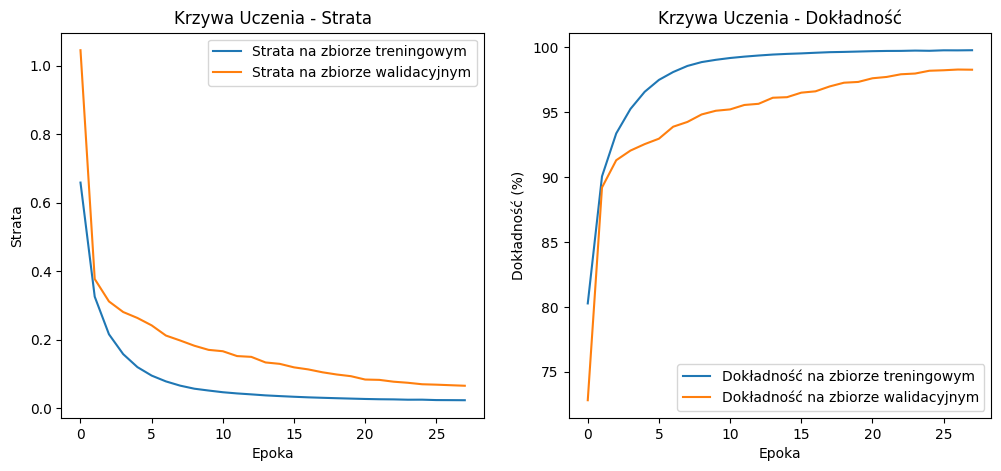

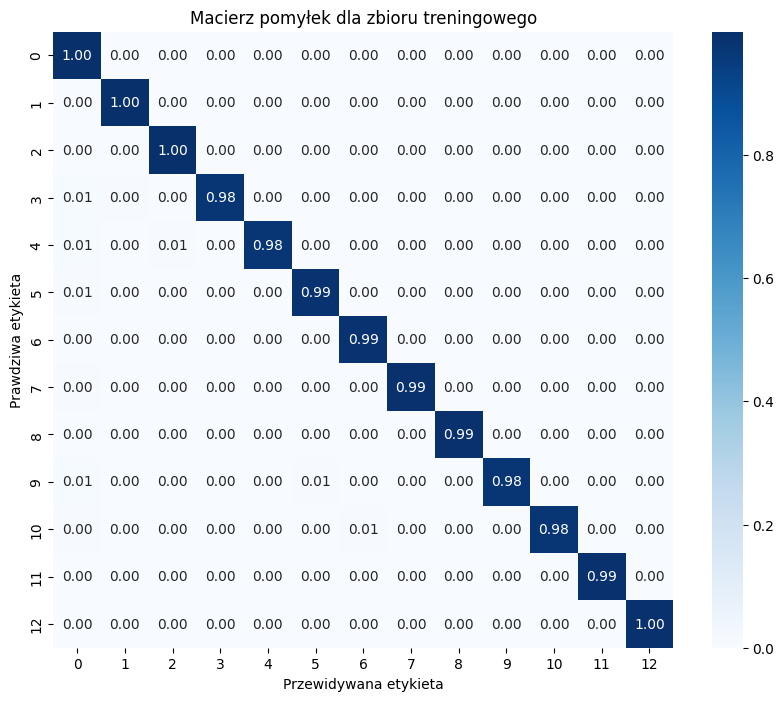

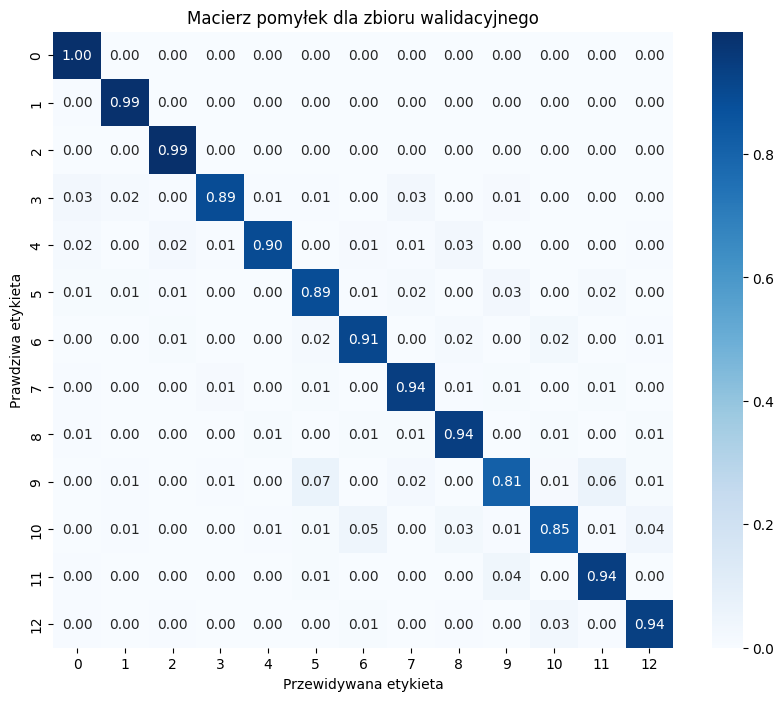

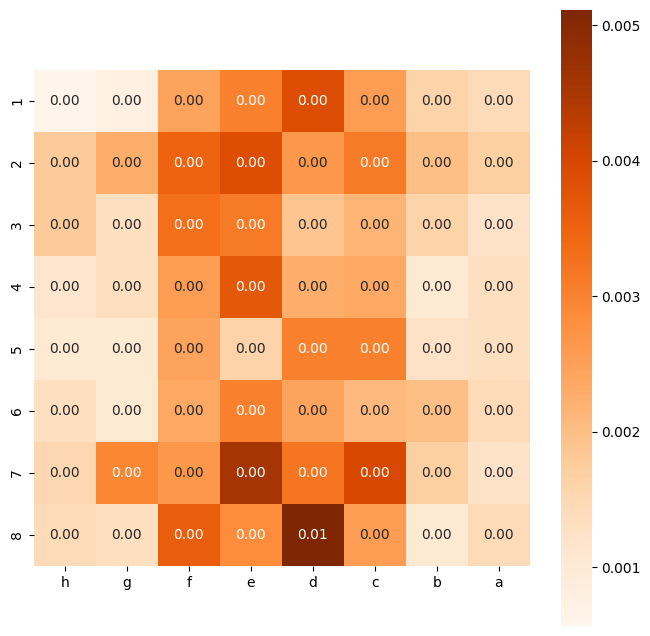

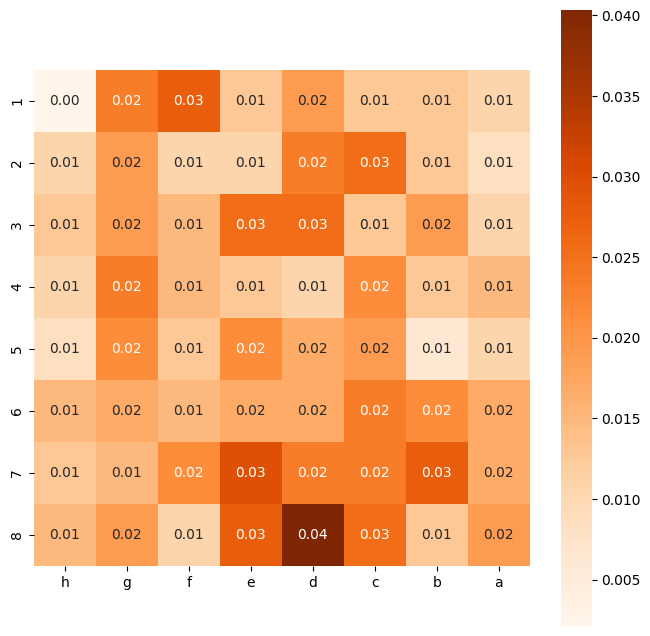

In [ ]:
num_epochs = 28
lr = 0.0001
lambda_l2 = 1e-3
weight_list = [p for n, p in model.named_parameters() if 'weight' in n]
bias_list = [p for n, p in model.named_parameters() if 'bias' in n]

optimizer = optim.Adam([
    {'params': weight_list, 'weight_decay': lambda_l2},
    {'params': bias_list, 'weight_decay': 0.0}], lr=lr)
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
criterion = nn.CrossEntropyLoss()
num_classes = 13
for epoch in tqdm(range(num_epochs)):
    model.train()

    train_class_correct = list(0. for i in range(num_classes))
    train_class_total = list(0. for i in range(num_classes))
    train_running_loss = 0.0
    all_train_predicted, all_train_labels = [], []
    for images, labels in tqdm(train_data_loader, leave=False):
        batch_size = labels.size(0)

        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs.view(-1, 13), labels.view(-1))
        loss.backward()
        optimizer.step()

        predicted_classes = torch.argmax(outputs, dim=2)
        c = (predicted_classes == labels).squeeze()
        train_running_loss += loss.item()
        for i in range(batch_size):
            for j in range(64):
                label = labels[i, j]
                train_class_correct[label] += c[i, j].item()
                train_class_total[label] += 1
        all_train_predicted.extend(predicted_classes.view(-1).cpu().numpy())
        all_train_labels.extend(labels.view(-1).cpu().numpy())

    train_accuracy = sum(train_class_correct) / sum(train_class_total) * 100
    train_loss = train_running_loss / len(train_data_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()

    val_class_correct = list(0. for i in range(num_classes))
    val_class_total = list(0. for i in range(num_classes))
    val_running_loss = 0.0
    all_val_predicted, all_val_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(val_data_loader, leave=False):
            batch_size = labels.size(0)

            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs.view(-1, 13), labels.view(-1))
            val_running_loss += loss.item()

            predicted_classes = torch.argmax(outputs, dim=2)
            c = (predicted_classes == labels).squeeze()
            for i in range(batch_size):
                for j in range(64):
                    label = labels[i, j]
                    val_class_correct[label] += c[i, j].item()
                    val_class_total[label] += 1
            all_val_predicted.extend(predicted_classes.view(-1).cpu().numpy())
            all_val_labels.extend(labels.view(-1).cpu().numpy())

    val_class_accuracy = [correct / total * 100 for correct, total in zip(val_class_correct, val_class_total)]
    val_accuracy = sum(val_class_correct) / sum(val_class_total) * 100
    val_loss = val_running_loss / len(val_data_loader)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    for i, accuracy in enumerate(val_class_accuracy):
        print(f'Dokladnosc dla klasy {i}: {accuracy:.2f}%')

    print(f'Epoka {epoch + 1}, Strata Treningowa: {train_loss:.4f}, Dokładność Treningowa: {train_accuracy:.2f}%, Strata Walidacyjna: {val_loss:.4f}')

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Strata na zbiorze treningowym')
plt.plot(val_losses, label='Strata na zbiorze walidacyjnym')
plt.title('Krzywa Uczenia - Strata')
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Dokładność na zbiorze treningowym')
plt.plot(val_accuracies, label='Dokładność na zbiorze walidacyjnym')
plt.title('Krzywa Uczenia - Dokładność')
plt.xlabel('Epoka')
plt.ylabel('Dokładność (%)')
plt.legend()
plt.show()

cm_train = confusion_matrix(all_train_labels, all_train_predicted)
cm_train_normalized = cm_train.astype('float') / cm_train.sum(axis=1, keepdims=True)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_train_normalized, annot=True, fmt=".2f", cmap="Blues")
plt.title('Macierz pomyłek dla zbioru treningowego')
plt.ylabel('Prawdziwa etykieta')
plt.xlabel('Przewidywana etykieta')
plt.show()

cm_val = confusion_matrix(all_val_labels, all_val_predicted)
cm_val_normalized = cm_val.astype('float') / cm_val.sum(axis=1, keepdims=True)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_val_normalized, annot=True, fmt=".2f", cmap="Blues")
plt.title('Macierz pomyłek dla zbioru walidacyjnego')
plt.ylabel('Prawdziwa etykieta')
plt.xlabel('Przewidywana etykieta')
plt.show()

n_boards = len(all_train_predicted) // 64
error_accumulator = np.zeros((8, 8))

for i in range(n_boards):
    pred_board = np.reshape(all_train_predicted[i*64:(i+1)*64], (8, 8))
    label_board = np.reshape(all_train_labels[i*64:(i+1)*64], (8, 8))
    error_accumulator += (pred_board != label_board)

error_rate = error_accumulator / n_boards

plt.figure(figsize=(8, 8))
sns.heatmap(error_rate, annot=True, cmap='Oranges', fmt='.2f', square=True, xticklabels=True, yticklabels=True)
plt.xticks(np.arange(8) + 0.5, labels=[chr(104 - i) for i in range(8)])
plt.yticks(np.arange(8) + 0.5, labels=[str(1 + i) for i in range(8)])
plt.show()

n_boards = len(all_val_predicted) // 64
error_accumulator = np.zeros((8, 8))

for i in range(n_boards):
    pred_board = np.reshape(all_val_predicted[i*64:(i+1)*64], (8, 8))
    label_board = np.reshape(all_val_labels[i*64:(i+1)*64], (8, 8))
    error_accumulator += (pred_board != label_board)

error_rate = error_accumulator / n_boards

plt.figure(figsize=(8, 8))
sns.heatmap(error_rate, annot=True, cmap='Oranges', fmt='.2f', square=True, xticklabels=True, yticklabels=True)
plt.xticks(np.arange(8) + 0.5, labels=[chr(104 - i) for i in range(8)])
plt.yticks(np.arange(8) + 0.5, labels=[str(1 + i) for i in range(8)])
plt.show()

In [ ]:
def get_class_name(class_id):
    class_names = {
        0: 'pole puste',
        1: 'czarny pionek', 2: 'biały pionek',
        3: 'czarny skoczek', 4: 'biały skoczek',
        5: 'czarny goniec', 6: 'biały goniec',
        7: 'czarna wieża', 8: 'biała wieża',
        9: 'czarny hetman', 10: 'biały hetman',
        11: 'czarny król', 12: 'biały król'
    }
    return class_names.get(class_id, "Nieznana klasa")
def label_to_piece_symbol(label):
    pieces_unicode = {
        0: '',
        1: '♟',
        2: '♙',
        3: '♞',
        4: '♘',
        5: '♝',
        6: '♗',
        7: '♜',
        8: '♖',
        9: '♛',
        10: '♕',
        11: '♚',
        12: '♔',
    }
    return pieces_unicode.get(label, '')

def convert_labels_to_chess_layout(labels):
    return [label_to_piece_symbol(label) for label in labels.flatten()]

def create_chessboard_image(pieces_layout_flat, output_size=(240, 240)):
    board_size = 8
    pieces_layout = np.array(pieces_layout_flat).reshape(board_size, board_size)

    color_light = '#EEEED5'
    color_dark = '#7D945D'

    chess_board_colors = np.zeros((board_size, board_size, 3))
    for i in range(board_size):
        for j in range(board_size):
            if (i + j) % 2 == 0:
                chess_board_colors[i, j] = np.array([238, 238, 213]) / 255
            else:
                chess_board_colors[i, j] = np.array([125, 148, 93]) / 255

    def plot_piece(ax, row, col, piece):
        ax.text(col, row, piece, fontsize=36, ha='center', va='center', fontfamily='DejaVu Sans')

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(chess_board_colors)
    ax.axis('off')

    for row in range(board_size):
        for col in range(board_size):
            piece = pieces_layout[row][col]
            if piece:
                plot_piece(ax, row, col, piece)

    buf = BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
    plt.close(fig)
    buf.seek(0)

    img = Image.open(buf)
    img_resized = img.resize(output_size, Image.ANTIALIAS)

    img_np = np.array(img_resized)

    return img_np



/tmp/ipykernel_42/2769634745.py:67: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img_resized = img.resize(output_size, Image.ANTIALIAS)


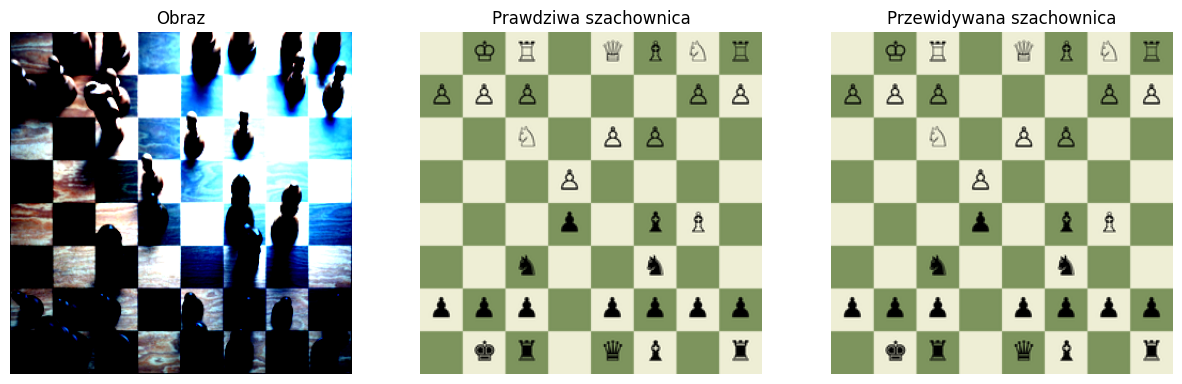

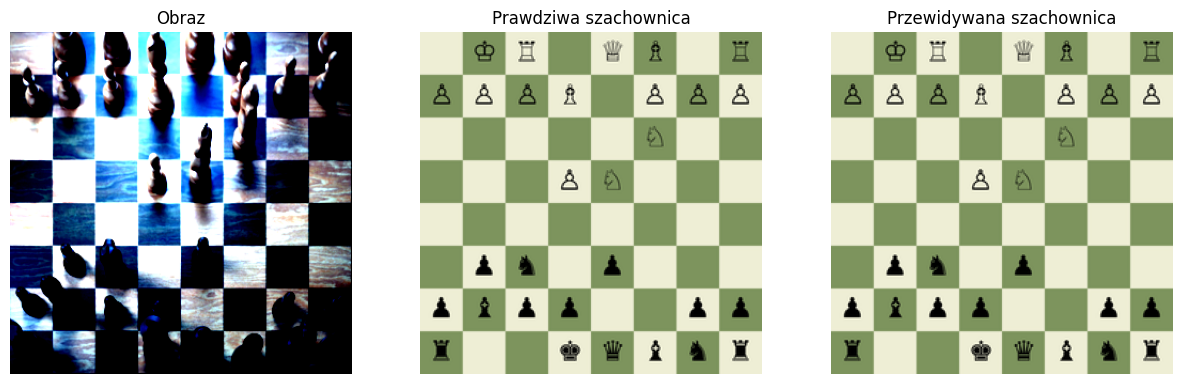

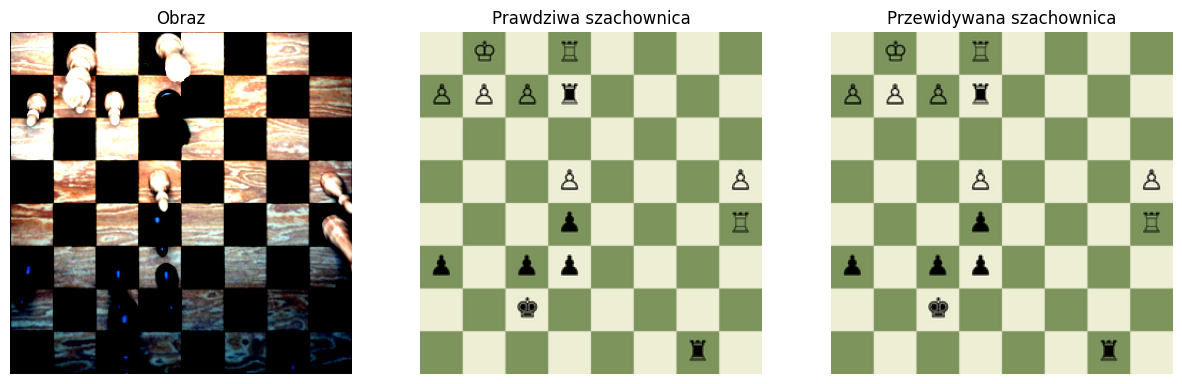

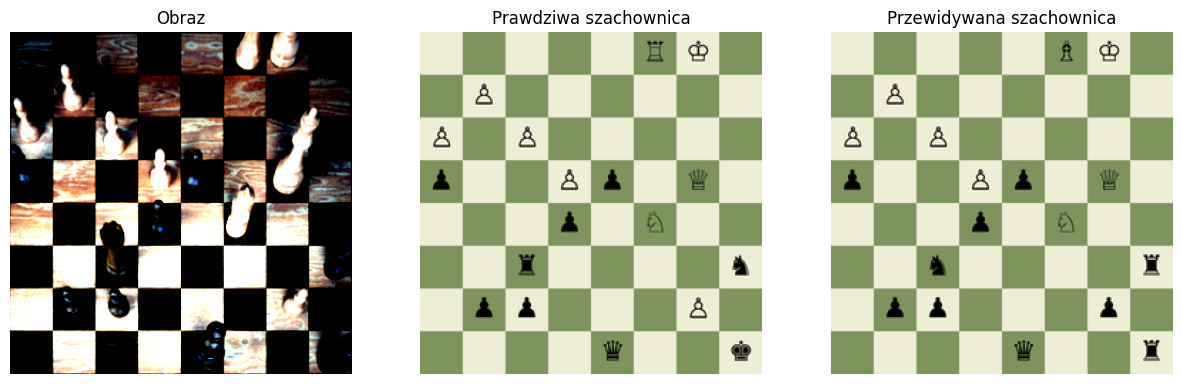

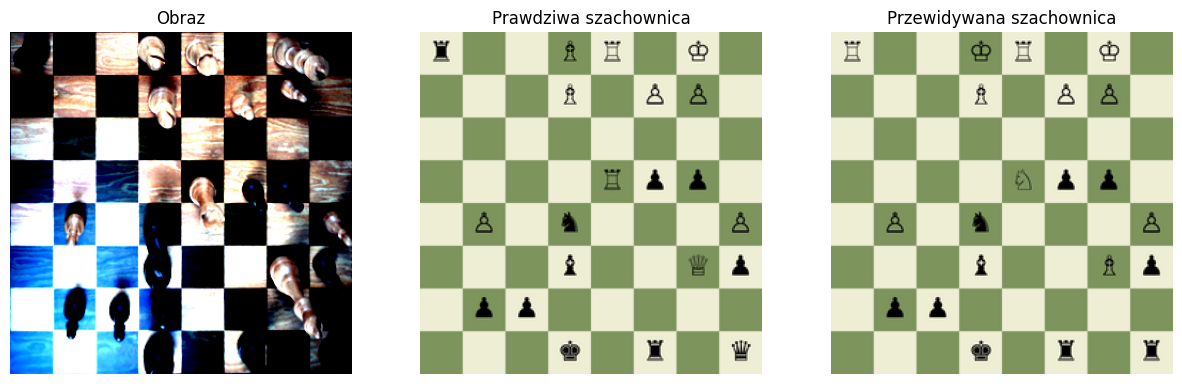

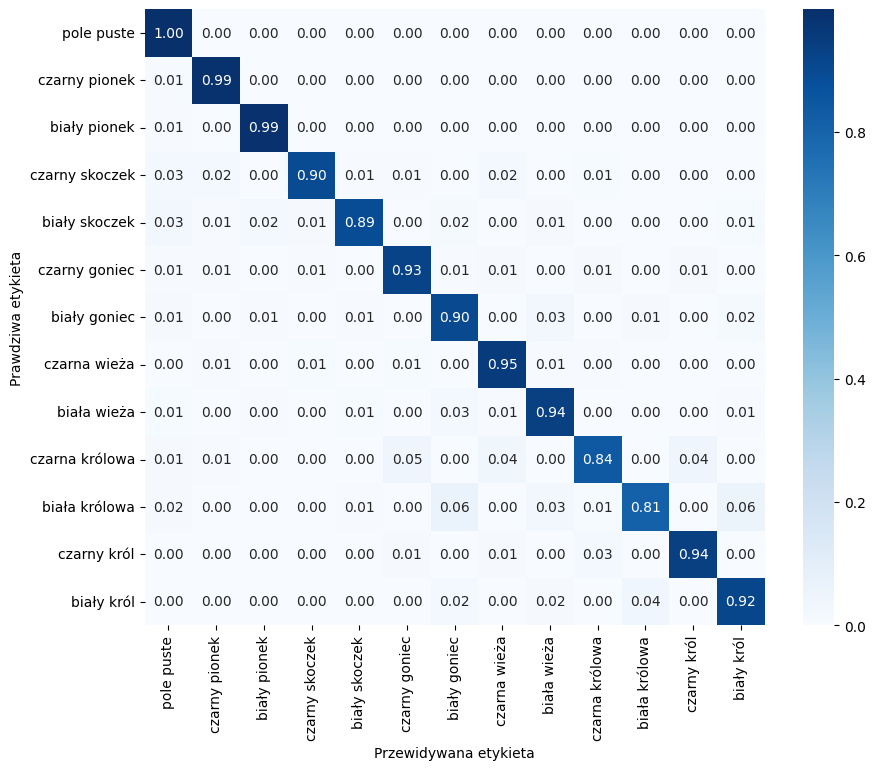

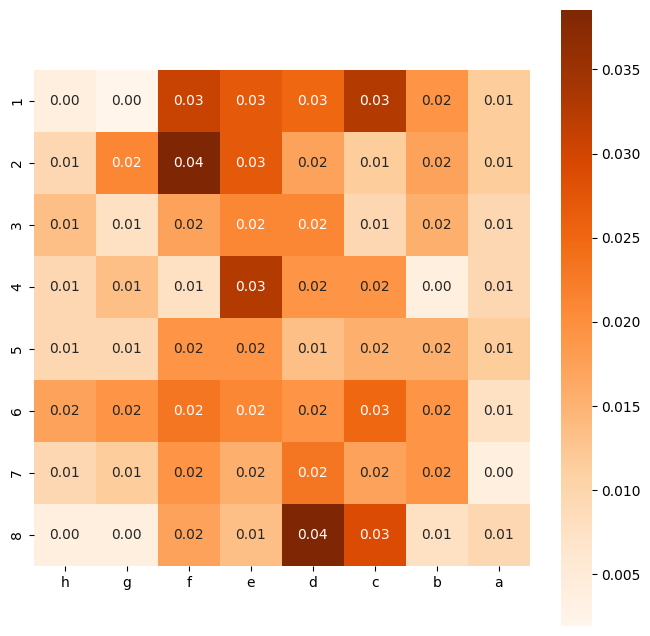

Dokładność na zestawie testowym: 98.37
Uśredniona dokładność klas na zestawie testowym: 92.26
Najgorsza pojedyńcza dokładność na zestawie testowym: 92.19


In [ ]:
model.eval()

correct = 0
total = 0

all_preds = []
all_labels = []
good_max_images_to_show = 3
bad_max_images_to_show = 3
good_images_shown = 0
bad_images_shown = 0
good_accuracy_threshold = 1
bad_accuracy_threshold = 0.9220
accurancies = []
num_classes = 13
class_correct = list(0. for i in range(num_classes))
class_total = list(0. for i in range(num_classes))
empty_label_value = 0
with torch.no_grad():
    for images, labels in test_data_loader:
        batch_size = labels.size(0)
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        predicted_classes = torch.argmax(outputs, dim=2)

        all_preds.extend(predicted_classes.view(-1).cpu().numpy())
        all_labels.extend(labels.view(-1).cpu().numpy())

        correct_tensor = (predicted_classes == labels)
        for idx in range(batch_size):
            accuracy = (predicted_classes[idx] == labels[idx]).float().mean()
            for j in range(64):
                label = labels[idx, j].item()
                class_correct[label] += correct_tensor[idx, j].item()
                class_total[label] += 1
            if good_images_shown < good_max_images_to_show and accuracy >= good_accuracy_threshold:
                fig, axes = plt.subplots(1, 3, figsize=(15, 5))
                img = images[idx].cpu().numpy().transpose((1, 2, 0))
                img = np.clip(img, 0, 1)

                ax = axes[0]
                ax.axis('off')
                ax.imshow(img)
                ax.set_title("Obraz")

                true_chessboard = labels[idx].cpu().numpy().reshape(8, 8)
                predicted_symbols = convert_labels_to_chess_layout(true_chessboard)
                img_np = create_chessboard_image(predicted_symbols, output_size=(240, 240))
                ax = axes[1]
                ax.axis('off')
                ax.imshow(img_np)
                ax.set_title("Prawdziwa szachownica")

                predicted_chessboard = predicted_classes[idx].cpu().numpy().reshape(8, 8)
                predicted_symbols = convert_labels_to_chess_layout(predicted_chessboard)
                img_np = create_chessboard_image(predicted_symbols, output_size=(240, 240))
                ax = axes[2]
                ax.axis('off')
                ax.imshow(img_np)
                ax.set_title("Przewidywana szachownica")

                good_images_shown += 1
            elif bad_images_shown < bad_max_images_to_show and accuracy <= bad_accuracy_threshold:
                fig, axes = plt.subplots(1, 3, figsize=(15, 5))
                img = images[idx].cpu().numpy().transpose((1, 2, 0))
                img = np.clip(img, 0, 1)
                ax = axes[0]
                ax.axis('off')
                ax.imshow(img)
                ax.set_title("Obraz")

                true_chessboard = labels[idx].cpu().numpy().reshape(8, 8)
                predicted_symbols = convert_labels_to_chess_layout(true_chessboard)
                img_np = create_chessboard_image(predicted_symbols, output_size=(240, 240))
                ax = axes[1]
                ax.axis('off')
                ax.imshow(img_np)
                ax.set_title("Prawdziwa szachownica")

                predicted_chessboard = predicted_classes[idx].cpu().numpy().reshape(8, 8)
                predicted_symbols = convert_labels_to_chess_layout(predicted_chessboard)
                img_np = create_chessboard_image(predicted_symbols, output_size=(240, 240))
                ax = axes[2]
                ax.axis('off')
                ax.imshow(img_np)
                ax.set_title("Przewidywana szachownica")

                bad_images_shown += 1
            accurancies.append(accuracy)
        correct += (predicted_classes == labels).sum().item()
        total += labels.numel()

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

axis_labels = [get_class_name(i) for i in range(13)]

sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=axis_labels, yticklabels=axis_labels)
plt.ylabel('Prawdziwa etykieta')
plt.xlabel('Przewidywana etykieta')
plt.show()

n_boards = len(all_preds) // 64
error_accumulator = np.zeros((8, 8))

for i in range(n_boards):
    pred_board = np.reshape(all_preds[i*64:(i+1)*64], (8, 8))
    label_board = np.reshape(all_labels[i*64:(i+1)*64], (8, 8))
    error_accumulator += (pred_board != label_board)

error_rate = error_accumulator / n_boards

plt.figure(figsize=(8, 8))
sns.heatmap(error_rate, annot=True, cmap='Oranges', fmt='.2f', square=True, xticklabels=True, yticklabels=True)
plt.xticks(np.arange(8) + 0.5, labels=[chr(104 - i) for i in range(8)])
plt.yticks(np.arange(8) + 0.5, labels=[str(i+1) for i in range(8)])
plt.show()

class_accuracies = [100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]
class_accuracy = sum(class_accuracies) / num_classes
accuracy = (correct / total)*100
print(f'Dokładność na zestawie testowym: {accuracy:.2f}')
print(f'Uśredniona dokładność klas na zestawie testowym: {class_accuracy:.2f}')
print(f'Najgorsza pojedyńcza dokładność na zestawie testowym: {min(accurancies)*100:.2f}')

In [ ]:
torch.save(model, 'model.pth')